In [1]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import datasets

In [48]:
boston = datasets.load_boston()
boston.keys()


dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [47]:
print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [14]:
boston["data"]

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [9]:
def rmse(objetivo, estimaciones):
    return np.sqrt(metrics.mean_squared_error(objetivo, estimaciones)
                  )

def adjusted_r2(objetivo, estimaciones, n, k):
    r2 = metrics.r2_score(objetivo, estimaciones)
    return 1 - (1-r2)*(n-1) / (n - k - 1)

def evaluar_modelo(objetivo, estimaciones, n, k):
    return {
        "rmse": rmse(objetivo, estimaciones),
        "mae": metrics.mean_absolute_error(objetivo, estimaciones),
        "adjusted_r2": adjusted_r2(objetivo, estimaciones, n, k)
           }

In [49]:
modelo_ols = LinearRegression()

modelo_ols.fit(X=boston["data"], y=boston["target"])

modelo_ols_preds = modelo_ols.predict(boston["data"])

In [50]:
RESULTADOS = {}

In [51]:
N = boston["data"].shape[0]

RESULTADOS["ols"] = evaluar_modelo(
    boston["target"],
    modelo_ols_preds,
    N,
    len(modelo_ols.coef_)
)

RESULTADOS

{'ols': {'rmse': 4.679191295697281,
  'mae': 3.2708628109003115,
  'adjusted_r2': 0.733789726372463}}

Hasta este momento hemos usado todos los datos como entrenamiento, de modo que posiblemente tengamos problemas de sobreajuste y por lo tanto tengamos errores si introducimos datos nuevos. Lo que haremos entonces es dividir la tabla para reentrenar el modelo.

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
train_test_split?

In [54]:
boston["data"].shape

(506, 13)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
     boston["data"], boston["target"],
     test_size=0.33, random_state=13
)

In [56]:
print(X_train.shape, y_train.shape)

(339, 13) (339,)


In [57]:
print(X_test.shape, y_test.shape)

(167, 13) (167,)


In [58]:
# Preparamos el modelo
modelo_ols = LinearRegression()

In [59]:
# Ajustamos el modelo entrenándolo
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)

# Obtenemos los resultados del modelo recién entrenado
RESULTADOS["ols_train"] = evaluar_modelo(
    y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

Hasta este momento, los coeficientes de la regresión en el modelo entrenado están guardados en ``modelo_ols.intercept_`` y ``modelo_ols.coef_``:

In [61]:
{"intercepcion":modelo_ols.intercept_,"coeficientes":modelo_ols.coef_}

{'intercepcion': 37.343088054122056,
 'coeficientes': array([-1.62247915e-01,  6.04934413e-02,  1.19068521e-02,  3.92827458e+00,
        -1.21499389e+01,  3.40553680e+00,  5.85293339e-03, -1.43670161e+00,
         3.69431633e-01, -1.41076708e-02, -9.75342185e-01,  8.27579593e-03,
        -5.94871223e-01])}

Utilizando estos parámetros, aplicamos a ``X_test``, el conjunto de prueba, para obtener las predicciones.

In [62]:
modelo_ols_test_preds = modelo_ols.predict(X_test)

RESULTADOS["ols_test"] = evaluar_modelo(
    y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)

In [27]:
import pandas as pd

In [28]:
pd.DataFrame(RESULTADOS)

,ols,ols_train,ols_test
rmse,4.679191,4.721732,4.784178
mae,3.270863,3.300868,3.558434
adjusted_r2,0.733790,0.731491,0.688716


Vemos que al separar los datos de entrenamiento y los de test se obtiene un resultado peor al evaluar los datos de train.

Podríamos parar aquí y decir *"El error RMSE de mi modelo es 4.787026"*, y podríamos pensar que esta todo bien ya que no hemos entrenado el modelo en los datos que hemos usado para evaluarlo.

Pero estaríamos en un grave error. ¿Por qué? 

Recordemos que hemos usado un `random_state=13` para la función `train_test_split` que garantiza que la separación de entrenamiento y test sea siempre la misma. Podemos usar cualquier número para este argumento.

Qué pasa si usamos por ejemplo `random_state=42`?

In [64]:
RESULTADOS = {}

X_train, X_test, y_train, y_test = train_test_split(
     boston["data"], boston["target"],
     test_size=0.33, random_state=42
)


modelo_ols = LinearRegression()
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)
modelo_ols_test_preds = modelo_ols.predict(X_test)


RESULTADOS["ols_train"] = evaluar_modelo(
    y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

RESULTADOS["ols_test"] = evaluar_modelo(
    y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)


pd.DataFrame(RESULTADOS)

,ols_train,ols_test
rmse,4.794269,4.552365
mae,3.376419,3.148256
adjusted_r2,0.728804,0.702889


¡El error en los datos de test es menor que en los de entrenamiento! ¿Por qué? Sencillamente, por que ha dado la casualidad de que hemos separado los datos de una forma que los datos de test son muy fáciles de estimar.

Para ver la magnitud del error en el que estamos cayendo al hacer una sola separación entre test y entrenamiento, vamos a probar un monton de semillas y ver cual es el rango del error que se puede obtener 

In [65]:
model=LinearRegression()
results = []
def test_seed(seed):
    X_train, X_test, y_train, y_test = train_test_split(
     boston["data"], boston["target"],
     test_size=0.33, random_state=seed
    )
    test_preds = model.fit(X_train, y_train).predict(X_test)
    seed_rmse = rmse(y_test, test_preds)
    results.append([seed_rmse, seed])

In [66]:
for i in range(1000):
    test_seed(i)

In [32]:
results[:5]

[[5.15350190084766, 0],
 [4.549557752626553, 1],
 [4.817966577147588, 2],
 [4.822833248024285, 3],
 [5.559184699608027, 4]]

In [67]:
results_sorted = sorted(results, key=lambda x: x[0], reverse=False)

In [68]:
results_sorted[0]

[3.631314217076934, 635]

In [69]:
results_sorted[-1]

[6.788054714003143, 645]

**Validación Cruzada (Cross Validation)**

Vemos que entre la semilla con menor error de test y la semilla con mayor error hay una diferencia casi del doble!

Una forma de evitar el cometer este error es mediante la **Validación cruzada**

![cross_val](https://cdn-images-1.medium.com/max/1600/1*J2B_bcbd1-s1kpWOu_FZrg.png)

In [36]:
from sklearn.model_selection import cross_val_score

In [37]:
cross_val_score?

In [38]:
modelo_ols = LinearRegression()
X = boston["data"]
y = boston["target"]

resultados_validación_cruzada = cross_val_score(
    estimator=modelo_ols, 
    X=X,
    y=y,
    scoring="neg_mean_squared_error", 
    cv=10
)

In [39]:
resultados_validación_cruzada

array([  -9.28694671,  -14.15128316,  -14.07360615,  -35.20692433,
        -31.88511666,  -19.83587796,   -9.94726918, -168.37537954,
        -33.32974507,  -10.96041068])

In [40]:
resultados_validación_cruzada.mean()

-34.705255944524815

In [41]:
def rmse_cross_val(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(metrics.mean_squared_error(y, y_pred))

In [42]:
resultados_cv = []
for i in range(10,200):
    cv_rmse = cross_val_score(
        estimator=modelo_ols, 
        X=X,
        y=y,
        scoring=rmse_cross_val, 
        cv=i
    ).mean()
    resultados_cv.append(cv_rmse)

In [70]:
#%matplotlib inline
import matplotlib.pyplot as plt

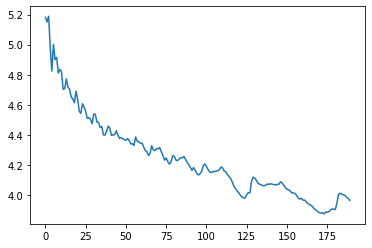

In [72]:
plt.plot(resultados_cv)

In [73]:
cross_validate?

In [45]:
from sklearn.model_selection import cross_validate
scoring = {"mae": "neg_mean_absolute_error", "rmse": rmse_cross_val}
estimator = modelo_ols
scores = cross_validate(estimator, boston["data"],
                        boston["target"], scoring=scoring,
                         cv=100, return_train_score=True)

In [46]:
pd.DataFrame(scores).mean()

fit_time      0.000728
score_time    0.000877
test_mae     -3.511687
train_mae    -3.270699
test_rmse     4.184166
train_rmse    4.676971
dtype: float64